In [3]:
!nvidia-smi

Sun Jul 10 15:37:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.02    Driver Version: 510.68.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   31C    P8    22W / 320W |    652MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
# from datetime import datetime
import time, datetime
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage import zoom
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#vit
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [6]:
model =timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   

In [7]:
trn_dir = glob('D:/project/wl_3class/train/*.jpg')
trn_df = pd.DataFrame(trn_dir, columns=['image_id'])
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df["label"]=trn_df["image_id"].apply(lambda x: 0 if "HP" in x else  1) 
train=trn_df

In [8]:
train

,image_id,label
0,AD_P00006_01_W_1.jpg,1
1,AD_P00006_03_W_1.jpg,1
2,AD_P00006_04_W_1.jpg,1
3,AD_P00006_05_W_1.jpg,1
4,AD_P00006_06_W_1.jpg,1
...,...,...
7313,SSL_S07987_03_W_1.jpg,1
7314,SSL_S07995_03_WF_1.jpg,1
7315,SSL_S08008_01_W_1.jpg,1
7316,SSL_S08161_03_W_1.jpg,1


In [9]:
train[train["label"]==0]

,image_id,label
5936,HP_P00010_01_W_1.jpg,0
5937,HP_P00010_02_W_1.jpg,0
5938,HP_P00010_03_W_1.jpg,0
5939,HP_P00026_02_W_1.jpg,0
5940,HP_P00026_06_WF_1.jpg,0
...,...,...
6696,HP_S06858_01_W_1.jpg,0
6697,HP_S06907_01_W_1.jpg,0
6698,HP_S06971_01_W_1.jpg,0
6699,HP_S06980_02_W_1.jpg,0


In [10]:
train.label.value_counts()

1    6553
0     765
Name: label, dtype: int64

In [11]:
val_dir = glob('D:/project/wl_3class/valid/*.jpg')
val_df = pd.DataFrame(val_dir, columns=['image_id'])
val_df['image_id'] = val_df['image_id'].apply(lambda x: os.path.basename(x))
val_df["label"]=val_df["image_id"].apply(lambda x:  0 if "HP" in x else  1 )
val_df
valid=val_df

In [12]:
valid=valid.sample(frac=1, replace=False, random_state=0).reset_index(drop=True)
valid

,image_id,label
0,AD_S01832_01_W_1.jpg,1
1,AD_P00246_02_W_1.jpg,1
2,SSL_S06325_05_W_1.jpg,1
3,AD_P00139_01_W_1.jpg,1
4,AD_P00989_05_W_1.jpg,1
...,...,...
418,HP_S02641_01_W_1.jpg,0
419,AD_S03601_01_W_1.jpg,1
420,AD_P01180_06_W_1.jpg,1
421,AD_P00478_14_W_1.jpg,1


In [13]:
valid.label.value_counts()

1    334
0     89
Name: label, dtype: int64

In [14]:
tst_dir = glob('D:/project/wl_3class/test/*.jpg')
tst_df = pd.DataFrame(tst_dir, columns=['image_id'])
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df["label"]=tst_df["image_id"].apply(lambda x:  0 if "HP" in x else  1 )
tst_df
test=tst_df

In [15]:
test.label.value_counts()

1    900
0    199
Name: label, dtype: int64

In [16]:
test

,image_id,label
0,AD_P00008_01_W_1.jpg,1
1,AD_P00008_02_W_1.jpg,1
2,AD_P00030_01_W_1.jpg,1
3,AD_P00030_02_W_1.jpg,1
4,AD_P00030_05_WF_1.jpg,1
...,...,...
1094,SSL_S06461_03_W_1.jpg,1
1095,SSL_S06505_01_W_1.jpg,1
1096,SSL_S06540_02_W_1.jpg,1
1097,SSL_S06870_05_W_1.jpg,1


In [17]:
test[test["label"]==0]

,image_id,label
696,HP_P00027_01_W_1.jpg,0
697,HP_P00027_03_W_1.jpg,0
698,HP_P00033_01_W_1.jpg,0
699,HP_P00200_01_W_1.jpg,0
700,HP_P00200_02_W_1.jpg,0
...,...,...
890,HP_S06560_01_W_1.jpg,0
891,HP_S06598_01_W_1.jpg,0
892,HP_S06690_03_W_1.jpg,0
893,HP_S06791_01_W_1.jpg,0


In [18]:
CFG = {
    'fold_num': 5,
    'seed': 3000,
    'model_arch': 'efficientnet_b0',
    'img_size': 384,
    'epochs': 100,
    'train_bs': 10,
    'valid_bs': 10,
    'T_0': 10,
    'lr': 1e-5,
    'min_lr': 1e-6,
    'weight_decay':1e-5,
    'num_workers': 0,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [19]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [20]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

In [21]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class ColonDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

In [22]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize, SmallestMaxSize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            #SmallestMaxSize(CFG['img_size']),
            RandomResizedCrop(CFG['img_size'], CFG['img_size'], p=0.5),
            Resize(CFG['img_size'], CFG['img_size']),   # (h, w)
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [23]:
class ColonImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class=2, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
        try :
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, n_class)
            #self.dropout = nn.Dropout(0.75)

        except :
            
            try : 
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, n_class)
            
            except :
                try:
                    n_features = self.model.head.fc.in_channels
                    self.model.head.fc = nn.Conv2d(n_features,n_class,kernel_size=(1, 1), stride=(1, 1))
            
                except:
                    n_features = self.model.head.in_features
                    self.model.head = nn.Linear(n_features, n_class)
            
    def forward(self, x):
        x = self.model(x)
        return x

In [24]:
def prepare_dataloader(df,valid,test, trn_idx, val_idx, trn_root='D:/temp_kyungbin/diagonis/@0718_wl_data/0906_SR/0906_SR',val_root='D:/temp_kyungbin/diagonis/@0718_wl_data/0906_SR/0906_SR',tst_root = 'D:/@image_data/open_data/@sun_data'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df
    valid_ = valid
        
    train_ds = ColonDataset(train_, trn_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = ColonDataset(valid_, val_root, transforms=get_valid_transforms(), output_label=True)
    test_ds = ColonDataset(test, tst_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle= False,    
        num_workers=CFG['num_workers'],
        sampler=BalanceClassSampler(labels=train_['label'].values, mode="upsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=True,
        pin_memory=False,
    )
    
    tst_loader = torch.utils.data.DataLoader(
        test_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=True,
        pin_memory=False,
    )
    return train_loader, val_loader,tst_loader

In [25]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels)
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
            
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    accuracy = (image_preds_all==image_targets_all).mean()
    
    print('train 2class accuracy = {:.5f}'.format(accuracy))
    print(matrix)
    
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
    
    return image_preds_all, accuracy, matrix,running_loss

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    result_loss=loss_sum/sample_num
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    acc = (image_preds_all==image_targets_all).mean()
    
    print('validation 2class accuracy = {:.5f}'.format(acc))
    print(matrix)
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return image_preds_all, acc, matrix,result_loss



def test_one_epoch(epoch, model, loss_fn1, tst_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(tst_loader), total=len(tst_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    result_loss=loss_sum/sample_num
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    acc = (image_preds_all==image_targets_all).mean()
    
    print('test 2class accuracy = {:.5f}'.format(acc))
    print(matrix)
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return image_preds_all, acc, matrix,result_loss

In [26]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

wandb: Currently logged in as: kyungbin. Use `wandb login --relogin` to force relogin


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\albumentations\augmentations\transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Training with 0 started
5854 1464


epoch 0 loss: 0.6358: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:39<00:00,  8.19it/s]


train 2class accuracy = 0.60102
[[3342 3211]
 [2018 4535]]


epoch 0 loss: 0.6297: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.74it/s]


validation 2class accuracy = 0.64775
[[ 49  40]
 [109 225]]


epoch 0 loss: 0.5858: 100%|██████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.05it/s]


test 2class accuracy = 0.71611
[[119  80]
 [232 668]]


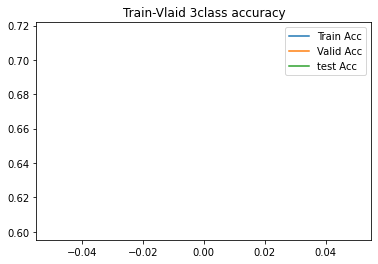

epoch 1 loss: 0.5963: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.54it/s]


train 2class accuracy = 0.66794
[[4323 2230]
 [2122 4431]]


epoch 1 loss: 0.6243: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.20it/s]


validation 2class accuracy = 0.64775
[[ 64  25]
 [124 210]]


epoch 1 loss: 0.5723: 100%|██████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.17it/s]


test 2class accuracy = 0.69791
[[138  61]
 [271 629]]


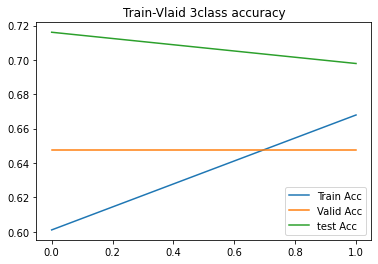

epoch 2 loss: 0.5803: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:32<00:00,  8.57it/s]


train 2class accuracy = 0.68656
[[4560 1993]
 [2115 4438]]


epoch 2 loss: 0.5533: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.50it/s]


validation 2class accuracy = 0.70449
[[ 54  35]
 [ 90 244]]


epoch 2 loss: 0.4919: 100%|██████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.92it/s]


test 2class accuracy = 0.75614
[[126  73]
 [195 705]]


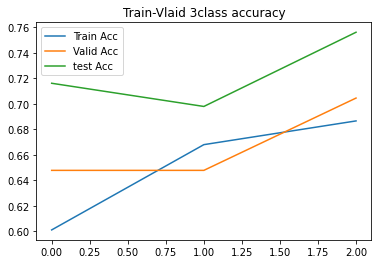

epoch 3 loss: 0.5787: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.55it/s]


train 2class accuracy = 0.70174
[[4635 1918]
 [1991 4562]]


epoch 3 loss: 0.6375: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.41it/s]


validation 2class accuracy = 0.63593
[[ 66  23]
 [131 203]]


epoch 3 loss: 0.5891: 100%|██████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.97it/s]


test 2class accuracy = 0.68881
[[154  45]
 [297 603]]


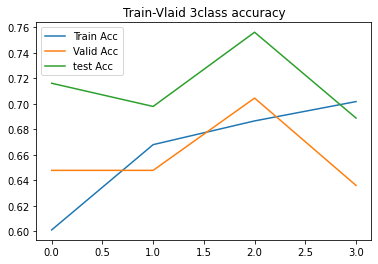

epoch 4 loss: 0.5483: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:32<00:00,  8.57it/s]


train 2class accuracy = 0.71372
[[4743 1810]
 [1942 4611]]


epoch 4 loss: 0.6722: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.73it/s]


validation 2class accuracy = 0.61229
[[ 68  21]
 [143 191]]


epoch 4 loss: 0.6143: 100%|██████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.45it/s]


test 2class accuracy = 0.66970
[[160  39]
 [324 576]]


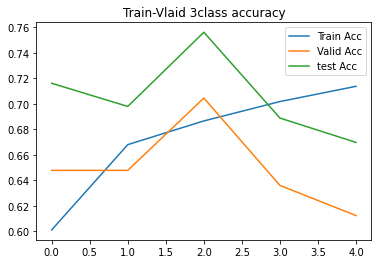

epoch 5 loss: 0.5438: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.53it/s]


train 2class accuracy = 0.72364
[[4817 1736]
 [1886 4667]]


epoch 5 loss: 0.6553: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.50it/s]


validation 2class accuracy = 0.62175
[[ 66  23]
 [137 197]]


epoch 5 loss: 0.6044: 100%|██████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.25it/s]


test 2class accuracy = 0.68335
[[161  38]
 [310 590]]


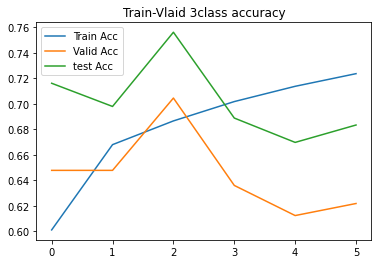

epoch 6 loss: 0.5431: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.52it/s]


train 2class accuracy = 0.72356
[[4769 1784]
 [1839 4714]]


epoch 6 loss: 0.6426: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.83it/s]


validation 2class accuracy = 0.64066
[[ 60  29]
 [123 211]]


epoch 6 loss: 0.5480: 100%|██████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.24it/s]


test 2class accuracy = 0.72520
[[147  52]
 [250 650]]


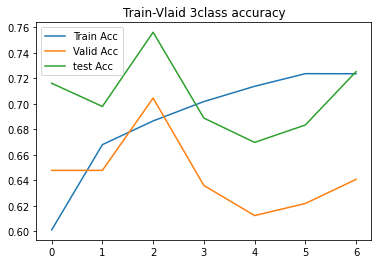

epoch 7 loss: 0.5203: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.36it/s]


train 2class accuracy = 0.73516
[[4915 1638]
 [1833 4720]]


epoch 7 loss: 0.6120: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.58it/s]


validation 2class accuracy = 0.68558
[[ 58  31]
 [102 232]]


epoch 7 loss: 0.5414: 100%|██████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.23it/s]


test 2class accuracy = 0.73157
[[146  53]
 [242 658]]


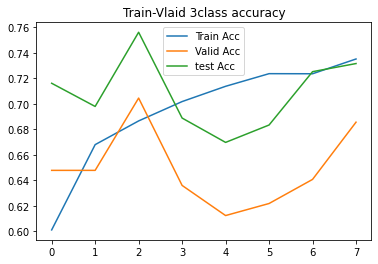

epoch 8 loss: 0.5184: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:28<00:00,  8.84it/s]


train 2class accuracy = 0.73669
[[4888 1665]
 [1786 4767]]


epoch 8 loss: 0.6191: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.56it/s]


validation 2class accuracy = 0.69267
[[ 61  28]
 [102 232]]


epoch 8 loss: 0.5592: 100%|██████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.28it/s]


test 2class accuracy = 0.72520
[[147  52]
 [250 650]]


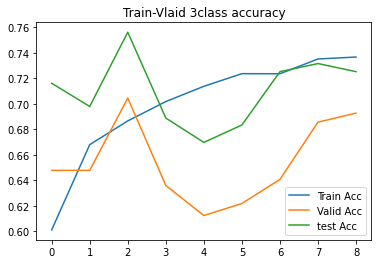

epoch 9 loss: 0.4911: 100%|████████████████████████████████████████████████████████| 1311/1311 [02:29<00:00,  8.78it/s]


train 2class accuracy = 0.74645
[[4952 1601]
 [1722 4831]]


epoch 9 loss: 0.6146: 100%|████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.20it/s]


validation 2class accuracy = 0.69267
[[ 63  26]
 [104 230]]


epoch 9 loss: 0.5459: 100%|██████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.53it/s]


test 2class accuracy = 0.73885
[[146  53]
 [234 666]]


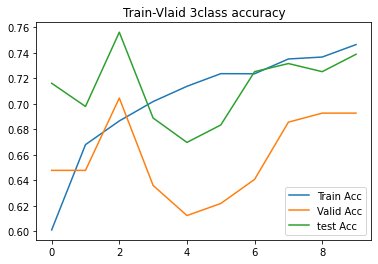

epoch 10 loss: 0.5057: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:32<00:00,  8.57it/s]


train 2class accuracy = 0.74851
[[4957 1596]
 [1700 4853]]


epoch 10 loss: 0.6079: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.44it/s]


validation 2class accuracy = 0.69267
[[ 60  29]
 [101 233]]


epoch 10 loss: 0.5287: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.34it/s]


test 2class accuracy = 0.75159
[[142  57]
 [216 684]]


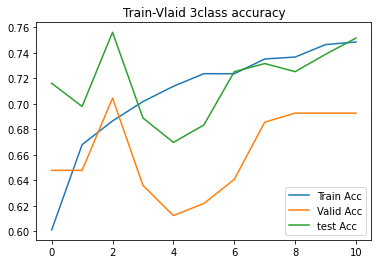

epoch 11 loss: 0.5200: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.54it/s]


train 2class accuracy = 0.75217
[[5008 1545]
 [1703 4850]]


epoch 11 loss: 0.6619: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.13it/s]


validation 2class accuracy = 0.67376
[[ 65  24]
 [114 220]]


epoch 11 loss: 0.5900: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.09it/s]


test 2class accuracy = 0.71338
[[159  40]
 [275 625]]


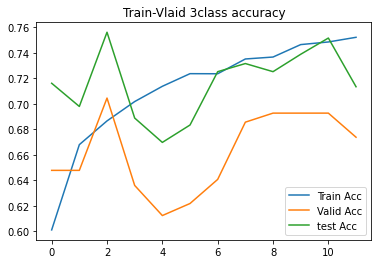

epoch 12 loss: 0.4862: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.50it/s]


train 2class accuracy = 0.75767
[[5040 1513]
 [1663 4890]]


epoch 12 loss: 0.6328: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.32it/s]


validation 2class accuracy = 0.69267
[[ 64  25]
 [105 229]]


epoch 12 loss: 0.5594: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.82it/s]


test 2class accuracy = 0.74340
[[147  52]
 [230 670]]


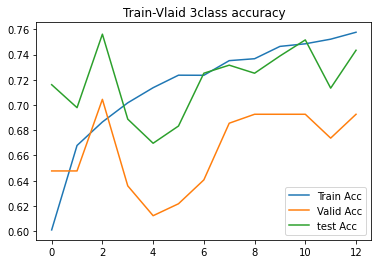

epoch 13 loss: 0.4740: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:32<00:00,  8.58it/s]


train 2class accuracy = 0.75500
[[5033 1520]
 [1691 4862]]


epoch 13 loss: 0.6637: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.24it/s]


validation 2class accuracy = 0.68322
[[ 65  24]
 [110 224]]


epoch 13 loss: 0.5861: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.15it/s]


test 2class accuracy = 0.73157
[[151  48]
 [247 653]]


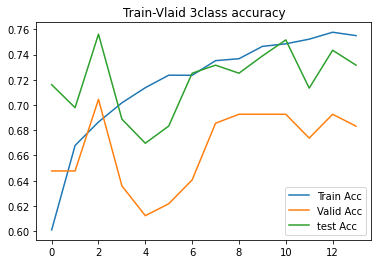

epoch 14 loss: 0.4914: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:31<00:00,  8.67it/s]


train 2class accuracy = 0.76835
[[5129 1424]
 [1612 4941]]


epoch 14 loss: 0.6725: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.47it/s]


validation 2class accuracy = 0.69504
[[ 61  28]
 [101 233]]


epoch 14 loss: 0.5824: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.17it/s]


test 2class accuracy = 0.73612
[[150  49]
 [241 659]]


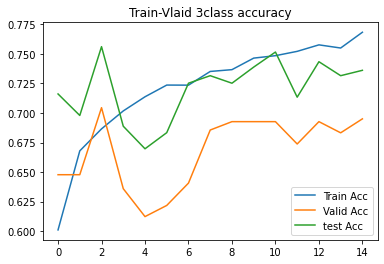

epoch 15 loss: 0.4729: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:31<00:00,  8.65it/s]


train 2class accuracy = 0.76080
[[5032 1521]
 [1614 4939]]


epoch 15 loss: 0.6806: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.09it/s]


validation 2class accuracy = 0.67612
[[ 64  25]
 [112 222]]


epoch 15 loss: 0.6139: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.10it/s]


test 2class accuracy = 0.71611
[[151  48]
 [264 636]]


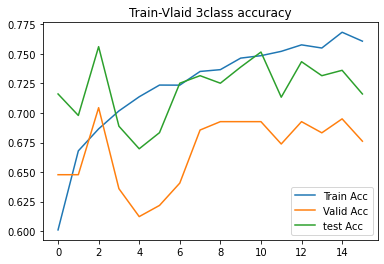

epoch 16 loss: 0.4750: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.57it/s]


train 2class accuracy = 0.76278
[[5089 1464]
 [1645 4908]]


epoch 16 loss: 0.6131: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.09it/s]


validation 2class accuracy = 0.70686
[[ 61  28]
 [ 96 238]]


epoch 16 loss: 0.5604: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.23it/s]


test 2class accuracy = 0.74067
[[147  52]
 [233 667]]


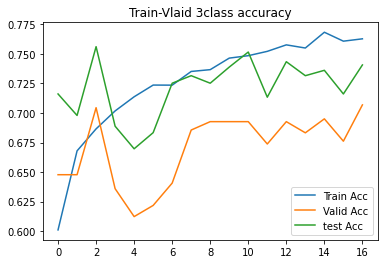

epoch 17 loss: 0.4816: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.50it/s]


train 2class accuracy = 0.76850
[[5110 1443]
 [1591 4962]]


epoch 17 loss: 0.6169: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.87it/s]


validation 2class accuracy = 0.72104
[[ 58  31]
 [ 87 247]]


epoch 17 loss: 0.5098: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.60it/s]


test 2class accuracy = 0.77525
[[137  62]
 [185 715]]


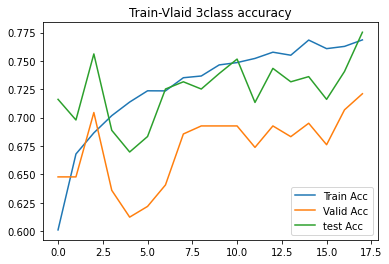

epoch 18 loss: 0.4640: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.51it/s]


train 2class accuracy = 0.76995
[[5129 1424]
 [1591 4962]]


epoch 18 loss: 0.5825: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.93it/s]


validation 2class accuracy = 0.71868
[[ 56  33]
 [ 86 248]]


epoch 18 loss: 0.5137: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.56it/s]


test 2class accuracy = 0.77889
[[143  56]
 [187 713]]


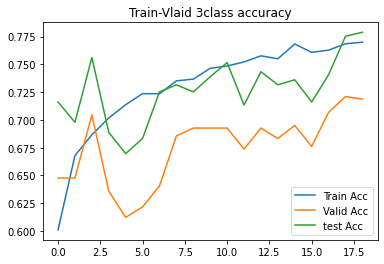

epoch 19 loss: 0.4544: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:31<00:00,  8.65it/s]


train 2class accuracy = 0.77445
[[5184 1369]
 [1587 4966]]


epoch 19 loss: 0.5985: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.67it/s]


validation 2class accuracy = 0.73286
[[ 58  31]
 [ 82 252]]


epoch 19 loss: 0.5125: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.17it/s]


test 2class accuracy = 0.77707
[[143  56]
 [189 711]]


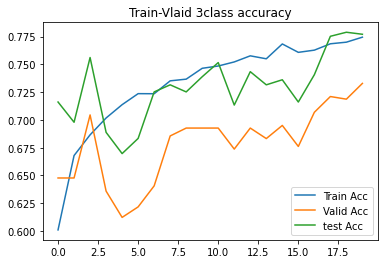

epoch 20 loss: 0.4563: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:32<00:00,  8.60it/s]


train 2class accuracy = 0.77743
[[5201 1352]
 [1565 4988]]


epoch 20 loss: 0.6218: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.16it/s]


validation 2class accuracy = 0.71158
[[ 62  27]
 [ 95 239]]


epoch 20 loss: 0.5509: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.57it/s]


test 2class accuracy = 0.74886
[[147  52]
 [224 676]]


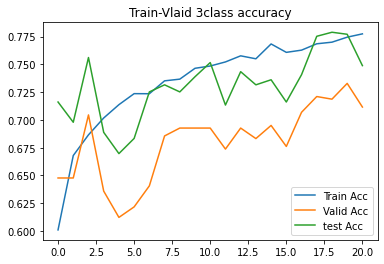

epoch 21 loss: 0.4692: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.53it/s]


train 2class accuracy = 0.78521
[[5282 1271]
 [1544 5009]]


epoch 21 loss: 0.6394: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.91it/s]


validation 2class accuracy = 0.72340
[[ 58  31]
 [ 86 248]]


epoch 21 loss: 0.5318: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.92it/s]


test 2class accuracy = 0.76433
[[144  55]
 [204 696]]


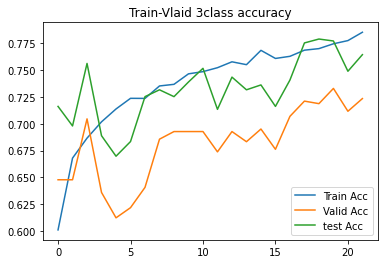

epoch 22 loss: 0.4407: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:30<00:00,  8.72it/s]


train 2class accuracy = 0.78338
[[5236 1317]
 [1522 5031]]


epoch 22 loss: 0.5779: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.16it/s]


validation 2class accuracy = 0.73759
[[ 53  36]
 [ 75 259]]


epoch 22 loss: 0.4950: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.98it/s]


test 2class accuracy = 0.77889
[[132  67]
 [176 724]]


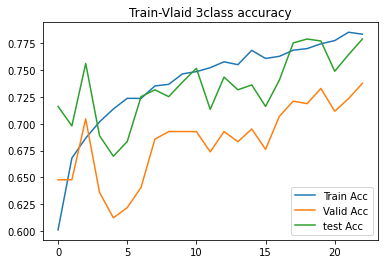

epoch 23 loss: 0.4218: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:30<00:00,  8.73it/s]


train 2class accuracy = 0.79185
[[5291 1262]
 [1466 5087]]


epoch 23 loss: 0.6103: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.20it/s]


validation 2class accuracy = 0.72340
[[ 54  35]
 [ 82 252]]


epoch 23 loss: 0.5248: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.00it/s]


test 2class accuracy = 0.77525
[[144  55]
 [192 708]]


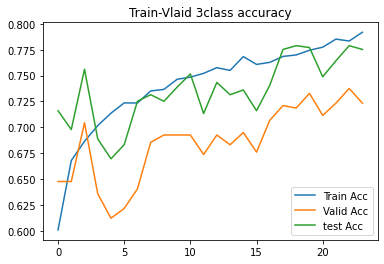

epoch 24 loss: 0.4480: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:32<00:00,  8.59it/s]


train 2class accuracy = 0.78781
[[5324 1229]
 [1552 5001]]


epoch 24 loss: 0.6690: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.40it/s]


validation 2class accuracy = 0.70922
[[ 62  27]
 [ 96 238]]


epoch 24 loss: 0.6097: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.36it/s]


test 2class accuracy = 0.74613
[[147  52]
 [227 673]]


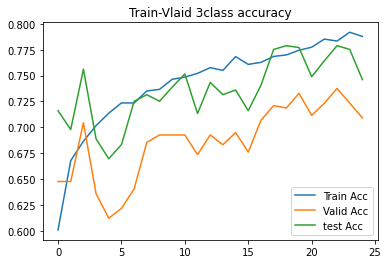

epoch 25 loss: 0.4341: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:31<00:00,  8.67it/s]


train 2class accuracy = 0.79956
[[5388 1165]
 [1462 5091]]


epoch 25 loss: 0.5961: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.66it/s]


validation 2class accuracy = 0.74468
[[ 57  32]
 [ 76 258]]


epoch 25 loss: 0.5127: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.36it/s]


test 2class accuracy = 0.77434
[[134  65]
 [183 717]]


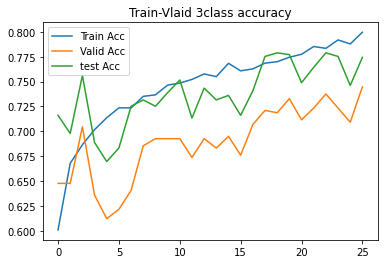

epoch 26 loss: 0.4331: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.31it/s]


train 2class accuracy = 0.80185
[[5364 1189]
 [1408 5145]]


epoch 26 loss: 0.6002: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.97it/s]


validation 2class accuracy = 0.74941
[[ 57  32]
 [ 74 260]]


epoch 26 loss: 0.5026: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.23it/s]


test 2class accuracy = 0.79345
[[140  59]
 [168 732]]


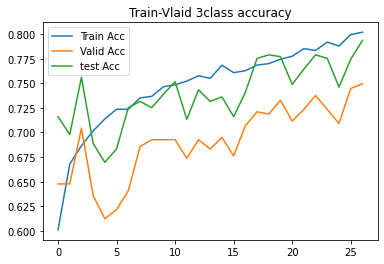

epoch 27 loss: 0.4548: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.56it/s]


train 2class accuracy = 0.79582
[[5364 1189]
 [1487 5066]]


epoch 27 loss: 0.6251: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 18.98it/s]


validation 2class accuracy = 0.73050
[[ 58  31]
 [ 83 251]]


epoch 27 loss: 0.5305: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.66it/s]


test 2class accuracy = 0.77798
[[143  56]
 [188 712]]


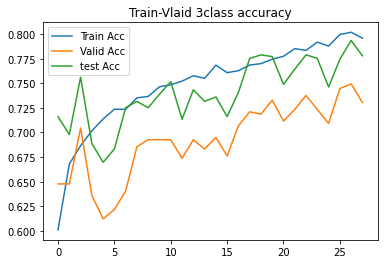

epoch 28 loss: 0.4170: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:35<00:00,  8.44it/s]


train 2class accuracy = 0.79994
[[5382 1171]
 [1451 5102]]


epoch 28 loss: 0.6013: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.19it/s]


validation 2class accuracy = 0.74468
[[ 56  33]
 [ 75 259]]


epoch 28 loss: 0.5068: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.91it/s]


test 2class accuracy = 0.78344
[[134  65]
 [173 727]]


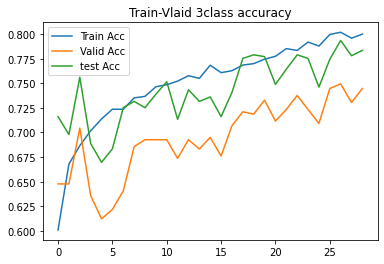

epoch 29 loss: 0.4061: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.52it/s]


train 2class accuracy = 0.80681
[[5399 1154]
 [1378 5175]]


epoch 29 loss: 0.6089: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.96it/s]


validation 2class accuracy = 0.74232
[[ 56  33]
 [ 76 258]]


epoch 29 loss: 0.5123: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.58it/s]


test 2class accuracy = 0.78162
[[134  65]
 [175 725]]


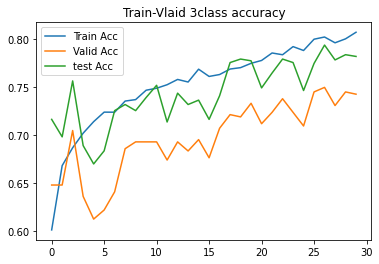

epoch 30 loss: 0.4235: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:54<00:00,  7.51it/s]


train 2class accuracy = 0.80772
[[5399 1154]
 [1366 5187]]


epoch 30 loss: 0.6381: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 17.21it/s]


validation 2class accuracy = 0.74941
[[ 56  33]
 [ 73 261]]


epoch 30 loss: 0.5225: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 16.64it/s]


test 2class accuracy = 0.78435
[[131  68]
 [169 731]]


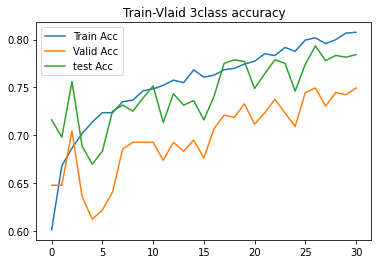

epoch 31 loss: 0.4059: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:48<00:00,  7.78it/s]


train 2class accuracy = 0.80696
[[5406 1147]
 [1383 5170]]


epoch 31 loss: 0.5590: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.89it/s]


validation 2class accuracy = 0.78014
[[ 53  36]
 [ 57 277]]


epoch 31 loss: 0.4945: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.50it/s]


test 2class accuracy = 0.79709
[[119  80]
 [143 757]]


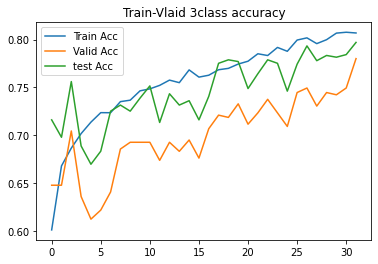

epoch 32 loss: 0.3977: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.36it/s]


train 2class accuracy = 0.81138
[[5416 1137]
 [1335 5218]]


epoch 32 loss: 0.5912: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.82it/s]


validation 2class accuracy = 0.76596
[[ 56  33]
 [ 66 268]]


epoch 32 loss: 0.5037: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.51it/s]


test 2class accuracy = 0.78981
[[130  69]
 [162 738]]


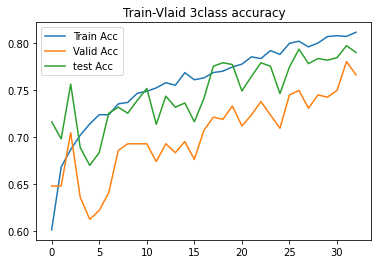

epoch 33 loss: 0.4201: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:35<00:00,  8.41it/s]


train 2class accuracy = 0.81520
[[5441 1112]
 [1310 5243]]


epoch 33 loss: 0.6008: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.35it/s]


validation 2class accuracy = 0.75177
[[ 55  34]
 [ 71 263]]


epoch 33 loss: 0.5278: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.21it/s]


test 2class accuracy = 0.77252
[[132  67]
 [183 717]]


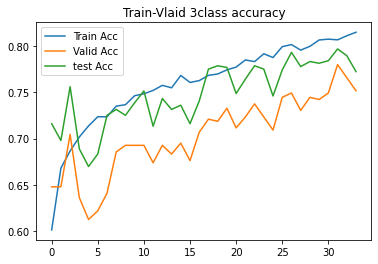

epoch 34 loss: 0.3850: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:32<00:00,  8.60it/s]


train 2class accuracy = 0.81650
[[5482 1071]
 [1334 5219]]


epoch 34 loss: 0.6226: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.64it/s]


validation 2class accuracy = 0.75650
[[ 53  36]
 [ 67 267]]


epoch 34 loss: 0.5313: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.36it/s]


test 2class accuracy = 0.78071
[[127  72]
 [169 731]]


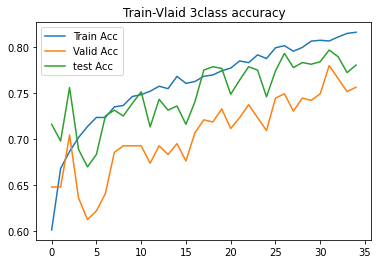

epoch 35 loss: 0.3841: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:32<00:00,  8.59it/s]


train 2class accuracy = 0.82214
[[5511 1042]
 [1289 5264]]


epoch 35 loss: 0.5975: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.45it/s]


validation 2class accuracy = 0.76832
[[ 50  39]
 [ 59 275]]


epoch 35 loss: 0.4991: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.66it/s]


test 2class accuracy = 0.79345
[[114  85]
 [142 758]]


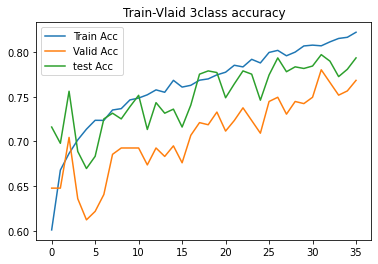

epoch 36 loss: 0.3836: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.40it/s]


train 2class accuracy = 0.81772
[[5508 1045]
 [1344 5209]]


epoch 36 loss: 0.6274: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.93it/s]


validation 2class accuracy = 0.76832
[[ 54  35]
 [ 63 271]]


epoch 36 loss: 0.5187: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.63it/s]


test 2class accuracy = 0.79436
[[122  77]
 [149 751]]


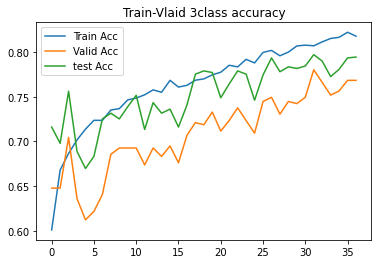

epoch 37 loss: 0.3716: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.53it/s]


train 2class accuracy = 0.81520
[[5446 1107]
 [1315 5238]]


epoch 37 loss: 0.6512: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.12it/s]


validation 2class accuracy = 0.75414
[[ 57  32]
 [ 72 262]]


epoch 37 loss: 0.5783: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.01it/s]


test 2class accuracy = 0.76615
[[129  70]
 [187 713]]


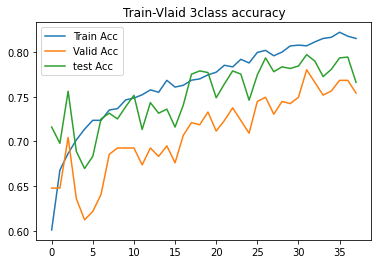

epoch 38 loss: 0.3729: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.52it/s]


train 2class accuracy = 0.82214
[[5540 1013]
 [1318 5235]]


epoch 38 loss: 0.6174: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.04it/s]


validation 2class accuracy = 0.76832
[[ 50  39]
 [ 59 275]]


epoch 38 loss: 0.5220: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.63it/s]


test 2class accuracy = 0.78799
[[114  85]
 [148 752]]


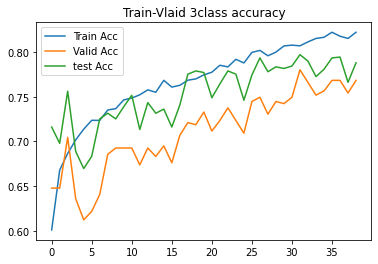

epoch 39 loss: 0.3840: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:35<00:00,  8.45it/s]


train 2class accuracy = 0.83031
[[5563  990]
 [1234 5319]]


epoch 39 loss: 0.5807: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.89it/s]


validation 2class accuracy = 0.76596
[[ 52  37]
 [ 62 272]]


epoch 39 loss: 0.4879: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.60it/s]


test 2class accuracy = 0.80255
[[112  87]
 [130 770]]


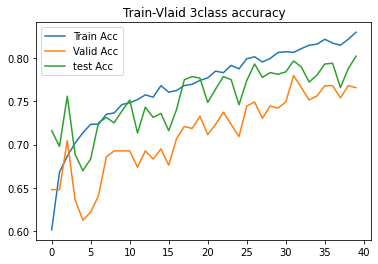

epoch 40 loss: 0.3758: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.49it/s]


train 2class accuracy = 0.82794
[[5532 1021]
 [1234 5319]]


epoch 40 loss: 0.6405: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.08it/s]


validation 2class accuracy = 0.76832
[[ 52  37]
 [ 61 273]]


epoch 40 loss: 0.5402: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.98it/s]


test 2class accuracy = 0.78890
[[131  68]
 [164 736]]


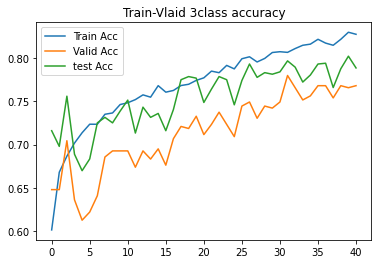

epoch 41 loss: 0.3874: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.52it/s]


train 2class accuracy = 0.82954
[[5522 1031]
 [1203 5350]]


epoch 41 loss: 0.6216: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.24it/s]


validation 2class accuracy = 0.76123
[[ 50  39]
 [ 62 272]]


epoch 41 loss: 0.5268: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.58it/s]


test 2class accuracy = 0.79527
[[118  81]
 [144 756]]


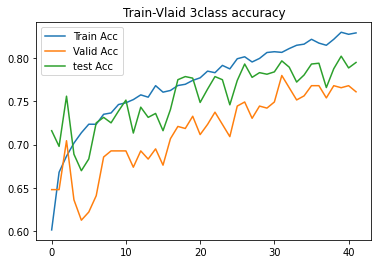

epoch 42 loss: 0.3873: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.49it/s]


train 2class accuracy = 0.82840
[[5558  995]
 [1254 5299]]


epoch 42 loss: 0.6358: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.73it/s]


validation 2class accuracy = 0.76832
[[ 47  42]
 [ 56 278]]


epoch 42 loss: 0.5034: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.76it/s]


test 2class accuracy = 0.79891
[[101  98]
 [123 777]]


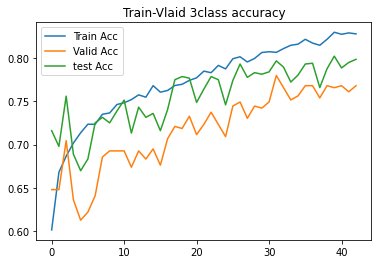

epoch 43 loss: 0.3569: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.49it/s]


train 2class accuracy = 0.83618
[[5628  925]
 [1222 5331]]


epoch 43 loss: 0.6325: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.00it/s]


validation 2class accuracy = 0.76123
[[ 53  36]
 [ 65 269]]


epoch 43 loss: 0.5473: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.88it/s]


test 2class accuracy = 0.79163
[[127  72]
 [157 743]]


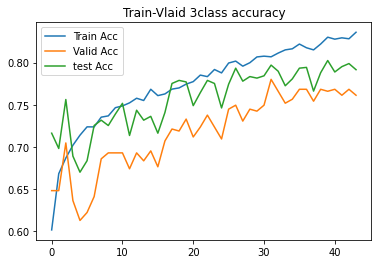

epoch 44 loss: 0.3625: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.54it/s]


train 2class accuracy = 0.82954
[[5555  998]
 [1236 5317]]


epoch 44 loss: 0.5816: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.11it/s]


validation 2class accuracy = 0.76832
[[ 52  37]
 [ 61 273]]


epoch 44 loss: 0.5310: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.88it/s]


test 2class accuracy = 0.78799
[[114  85]
 [148 752]]


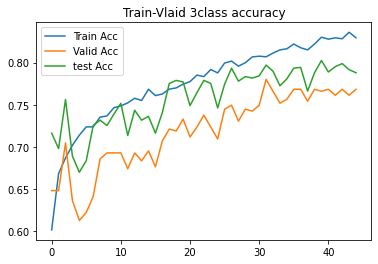

epoch 45 loss: 0.3508: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.56it/s]


train 2class accuracy = 0.84053
[[5633  920]
 [1170 5383]]


epoch 45 loss: 0.6030: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.02it/s]


validation 2class accuracy = 0.78014
[[ 50  39]
 [ 54 280]]


epoch 45 loss: 0.5154: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.87it/s]


test 2class accuracy = 0.79982
[[117  82]
 [138 762]]


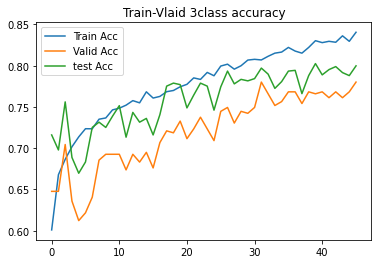

epoch 46 loss: 0.3345: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.50it/s]


train 2class accuracy = 0.83550
[[5625  928]
 [1228 5325]]


epoch 46 loss: 0.6397: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.03it/s]


validation 2class accuracy = 0.76359
[[ 51  38]
 [ 62 272]]


epoch 46 loss: 0.5327: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.73it/s]


test 2class accuracy = 0.79709
[[113  86]
 [137 763]]


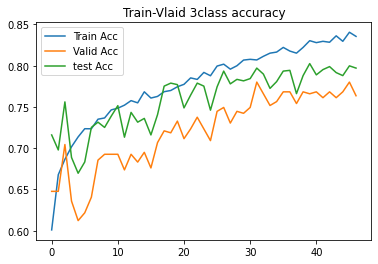

epoch 47 loss: 0.3547: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.52it/s]


train 2class accuracy = 0.84381
[[5668  885]
 [1162 5391]]


epoch 47 loss: 0.6504: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.25it/s]


validation 2class accuracy = 0.78251
[[ 48  41]
 [ 51 283]]


epoch 47 loss: 0.5228: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.14it/s]


test 2class accuracy = 0.80073
[[113  86]
 [133 767]]


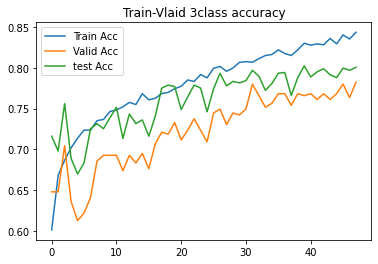

epoch 48 loss: 0.3414: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.55it/s]


train 2class accuracy = 0.84251
[[5643  910]
 [1154 5399]]


epoch 48 loss: 0.6271: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.13it/s]


validation 2class accuracy = 0.76832
[[ 48  41]
 [ 57 277]]


epoch 48 loss: 0.5167: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.63it/s]


test 2class accuracy = 0.80255
[[121  78]
 [139 761]]


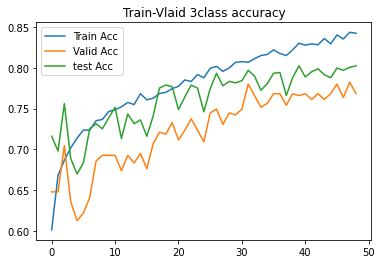

epoch 49 loss: 0.3490: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.53it/s]


train 2class accuracy = 0.84129
[[5639  914]
 [1166 5387]]


epoch 49 loss: 0.6728: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.07it/s]


validation 2class accuracy = 0.74468
[[ 47  42]
 [ 66 268]]


epoch 49 loss: 0.5847: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.70it/s]


test 2class accuracy = 0.78344
[[114  85]
 [153 747]]


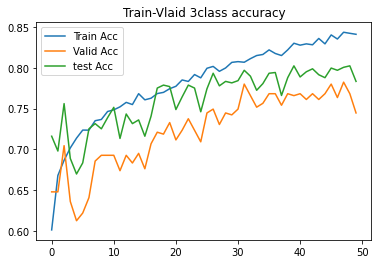

epoch 50 loss: 0.3364: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.50it/s]


train 2class accuracy = 0.84503
[[5683  870]
 [1161 5392]]


epoch 50 loss: 0.6552: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.99it/s]


validation 2class accuracy = 0.76123
[[ 47  42]
 [ 59 275]]


epoch 50 loss: 0.5239: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.67it/s]


test 2class accuracy = 0.79436
[[117  82]
 [144 756]]


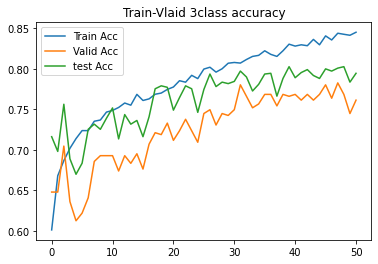

epoch 51 loss: 0.3535: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.53it/s]


train 2class accuracy = 0.84740
[[5672  881]
 [1119 5434]]


epoch 51 loss: 0.6305: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.91it/s]


validation 2class accuracy = 0.76596
[[ 50  39]
 [ 60 274]]


epoch 51 loss: 0.5713: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.92it/s]


test 2class accuracy = 0.78617
[[111  88]
 [147 753]]


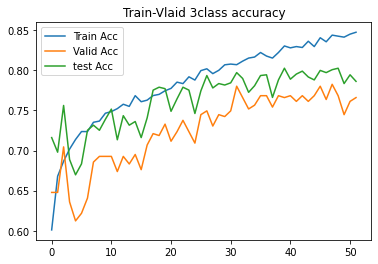

epoch 52 loss: 0.3062: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.53it/s]


train 2class accuracy = 0.85129
[[5693  860]
 [1089 5464]]


epoch 52 loss: 0.6997: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.92it/s]


validation 2class accuracy = 0.76596
[[ 50  39]
 [ 60 274]]


epoch 52 loss: 0.5610: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.77it/s]


test 2class accuracy = 0.79436
[[118  81]
 [145 755]]


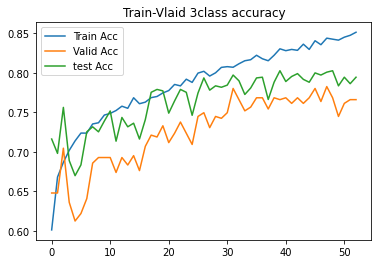

epoch 53 loss: 0.3312: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.48it/s]


train 2class accuracy = 0.84625
[[5664  889]
 [1126 5427]]


epoch 53 loss: 0.6439: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.03it/s]


validation 2class accuracy = 0.75650
[[ 51  38]
 [ 65 269]]


epoch 53 loss: 0.5785: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.64it/s]


test 2class accuracy = 0.78253
[[118  81]
 [158 742]]


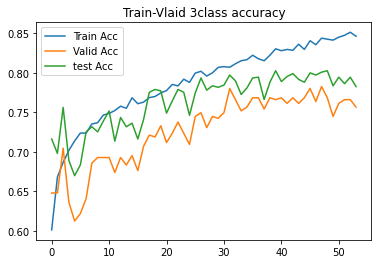

epoch 54 loss: 0.3233: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:35<00:00,  8.45it/s]


train 2class accuracy = 0.84915
[[5669  884]
 [1093 5460]]


epoch 54 loss: 0.6748: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.13it/s]


validation 2class accuracy = 0.77778
[[ 47  42]
 [ 52 282]]


epoch 54 loss: 0.5485: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.71it/s]


test 2class accuracy = 0.80346
[[112  87]
 [129 771]]


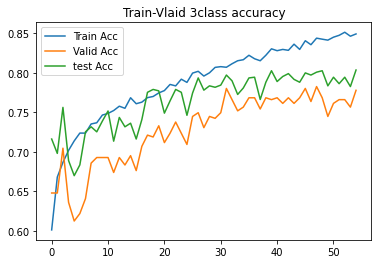

epoch 55 loss: 0.3134: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:40<00:00,  8.18it/s]


train 2class accuracy = 0.85259
[[5666  887]
 [1045 5508]]


epoch 55 loss: 0.6718: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.25it/s]


validation 2class accuracy = 0.76123
[[ 48  41]
 [ 60 274]]


epoch 55 loss: 0.5638: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.72it/s]


test 2class accuracy = 0.78981
[[112  87]
 [144 756]]


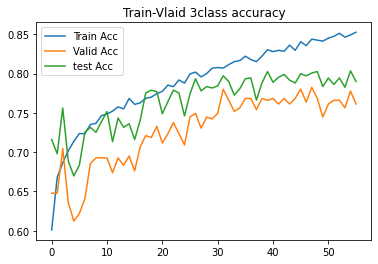

epoch 56 loss: 0.3380: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.33it/s]


train 2class accuracy = 0.85228
[[5725  828]
 [1108 5445]]


epoch 56 loss: 0.6596: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.16it/s]


validation 2class accuracy = 0.77069
[[ 44  45]
 [ 52 282]]


epoch 56 loss: 0.5392: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.88it/s]


test 2class accuracy = 0.79618
[[106  93]
 [131 769]]


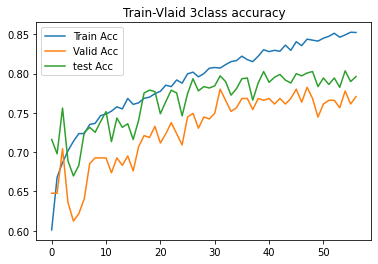

epoch 57 loss: 0.2995: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.32it/s]


train 2class accuracy = 0.85526
[[5700  853]
 [1044 5509]]


epoch 57 loss: 0.6450: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.34it/s]


validation 2class accuracy = 0.76596
[[ 45  44]
 [ 55 279]]


epoch 57 loss: 0.5319: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.88it/s]


test 2class accuracy = 0.80801
[[111  88]
 [123 777]]


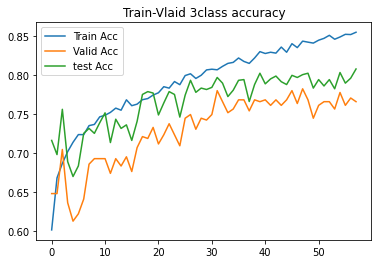

epoch 58 loss: 0.3429: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.35it/s]


train 2class accuracy = 0.85724
[[5754  799]
 [1072 5481]]


epoch 58 loss: 0.6773: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.59it/s]


validation 2class accuracy = 0.76596
[[ 47  42]
 [ 57 277]]


epoch 58 loss: 0.5334: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.00it/s]


test 2class accuracy = 0.79891
[[110  89]
 [132 768]]


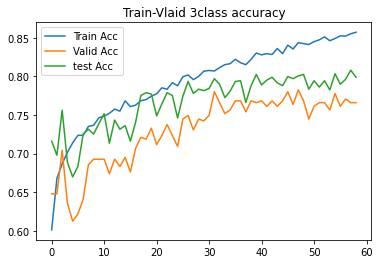

epoch 59 loss: 0.3283: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.34it/s]


train 2class accuracy = 0.85869
[[5758  795]
 [1057 5496]]


epoch 59 loss: 0.6721: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.09it/s]


validation 2class accuracy = 0.77069
[[ 48  41]
 [ 56 278]]


epoch 59 loss: 0.5784: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.98it/s]


test 2class accuracy = 0.79527
[[114  85]
 [140 760]]


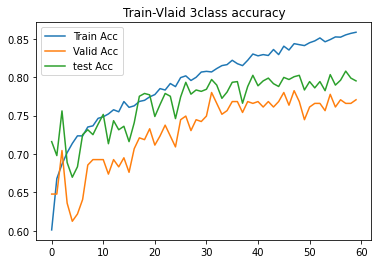

epoch 60 loss: 0.3133: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.40it/s]


train 2class accuracy = 0.86136
[[5771  782]
 [1035 5518]]


epoch 60 loss: 0.6540: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.14it/s]


validation 2class accuracy = 0.78014
[[ 47  42]
 [ 51 283]]


epoch 60 loss: 0.5479: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.74it/s]


test 2class accuracy = 0.80710
[[117  82]
 [130 770]]


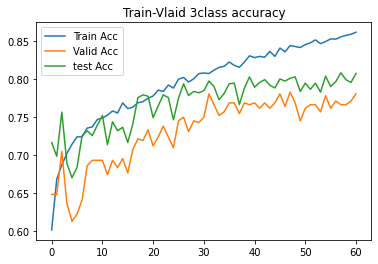

epoch 61 loss: 0.3100: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.54it/s]


train 2class accuracy = 0.85922
[[5744  809]
 [1036 5517]]


epoch 61 loss: 0.6680: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.17it/s]


validation 2class accuracy = 0.77541
[[ 44  45]
 [ 50 284]]


epoch 61 loss: 0.5520: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.76it/s]


test 2class accuracy = 0.80073
[[107  92]
 [127 773]]


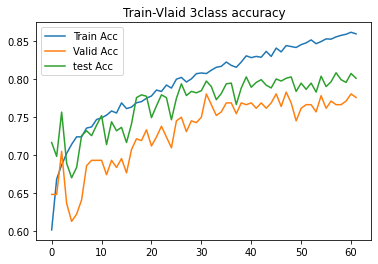

epoch 62 loss: 0.2970: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.56it/s]


train 2class accuracy = 0.85892
[[5759  794]
 [1055 5498]]


epoch 62 loss: 0.7076: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.19it/s]


validation 2class accuracy = 0.77305
[[ 45  44]
 [ 52 282]]


epoch 62 loss: 0.5427: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.76it/s]


test 2class accuracy = 0.81529
[[108  91]
 [112 788]]


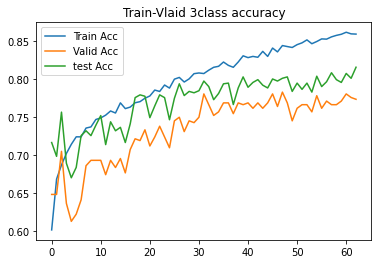

epoch 63 loss: 0.3119: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.53it/s]


train 2class accuracy = 0.86243
[[5768  785]
 [1018 5535]]


epoch 63 loss: 0.6951: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.12it/s]


validation 2class accuracy = 0.78014
[[ 46  43]
 [ 50 284]]


epoch 63 loss: 0.5521: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.88it/s]


test 2class accuracy = 0.81529
[[107  92]
 [111 789]]


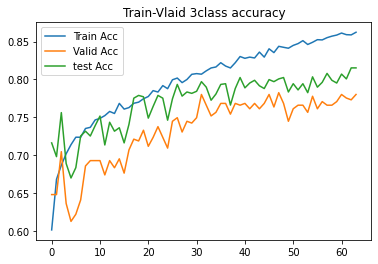

epoch 64 loss: 0.3078: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.51it/s]


train 2class accuracy = 0.86731
[[5784  769]
 [ 970 5583]]


epoch 64 loss: 0.6996: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.06it/s]


validation 2class accuracy = 0.77305
[[ 49  40]
 [ 56 278]]


epoch 64 loss: 0.5414: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.05it/s]


test 2class accuracy = 0.80801
[[103  96]
 [115 785]]


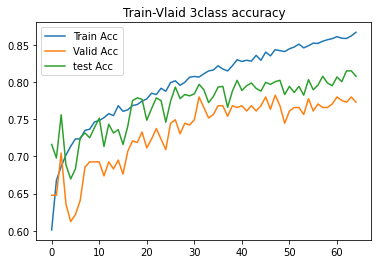

epoch 65 loss: 0.2877: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.49it/s]


train 2class accuracy = 0.86716
[[5811  742]
 [ 999 5554]]


epoch 65 loss: 0.7059: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.83it/s]


validation 2class accuracy = 0.77305
[[ 46  43]
 [ 53 281]]


epoch 65 loss: 0.5813: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.87it/s]


test 2class accuracy = 0.80437
[[109  90]
 [125 775]]


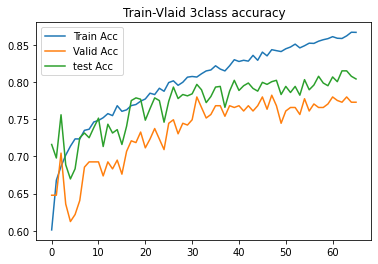

epoch 66 loss: 0.2855: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.40it/s]


train 2class accuracy = 0.86479
[[5777  776]
 [ 996 5557]]


epoch 66 loss: 0.7198: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.03it/s]


validation 2class accuracy = 0.78487
[[ 46  43]
 [ 48 286]]


epoch 66 loss: 0.5758: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.02it/s]


test 2class accuracy = 0.81074
[[115  84]
 [124 776]]


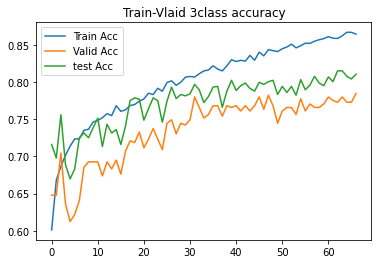

epoch 67 loss: 0.3069: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.32it/s]


train 2class accuracy = 0.86792
[[5802  751]
 [ 980 5573]]


epoch 67 loss: 0.7277: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.15it/s]


validation 2class accuracy = 0.78014
[[ 45  44]
 [ 49 285]]


epoch 67 loss: 0.5866: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.87it/s]


test 2class accuracy = 0.81074
[[111  88]
 [120 780]]


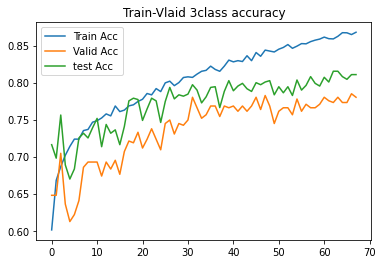

epoch 68 loss: 0.2902: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.34it/s]


train 2class accuracy = 0.86441
[[5758  795]
 [ 982 5571]]


epoch 68 loss: 0.7274: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.21it/s]


validation 2class accuracy = 0.76123
[[ 45  44]
 [ 57 277]]


epoch 68 loss: 0.5934: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.29it/s]


test 2class accuracy = 0.81438
[[111  88]
 [116 784]]


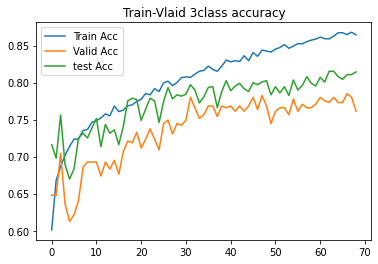

epoch 69 loss: 0.2816: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.39it/s]


train 2class accuracy = 0.87479
[[5847  706]
 [ 935 5618]]


epoch 69 loss: 0.7234: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.44it/s]


validation 2class accuracy = 0.79196
[[ 47  42]
 [ 46 288]]


epoch 69 loss: 0.5991: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.28it/s]


test 2class accuracy = 0.82439
[[110  89]
 [104 796]]


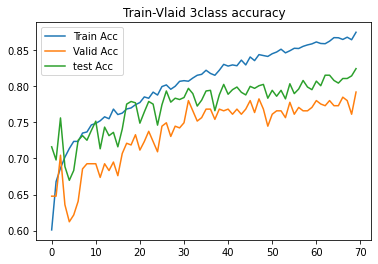

epoch 70 loss: 0.2791: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.34it/s]


train 2class accuracy = 0.87174
[[5819  734]
 [ 947 5606]]


epoch 70 loss: 0.7048: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 18.99it/s]


validation 2class accuracy = 0.79669
[[ 41  48]
 [ 38 296]]


epoch 70 loss: 0.5835: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.08it/s]


test 2class accuracy = 0.82257
[[ 99 100]
 [ 95 805]]


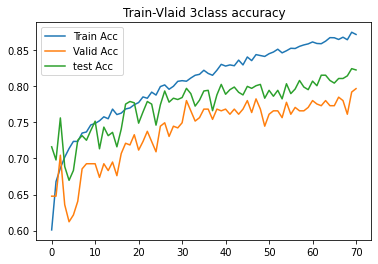

epoch 71 loss: 0.2872: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.31it/s]


train 2class accuracy = 0.86716
[[5787  766]
 [ 975 5578]]


epoch 71 loss: 0.7192: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.10it/s]


validation 2class accuracy = 0.76123
[[ 43  46]
 [ 55 279]]


epoch 71 loss: 0.5600: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.92it/s]


test 2class accuracy = 0.80437
[[111  88]
 [127 773]]


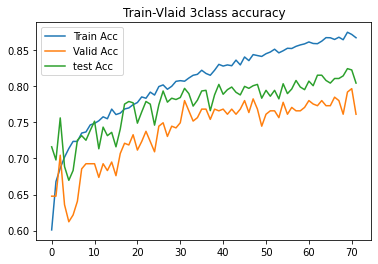

epoch 72 loss: 0.2918: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.36it/s]


train 2class accuracy = 0.86792
[[5761  792]
 [ 939 5614]]


epoch 72 loss: 0.7547: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.30it/s]


validation 2class accuracy = 0.78251
[[ 41  48]
 [ 44 290]]


epoch 72 loss: 0.5937: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.02it/s]


test 2class accuracy = 0.80710
[[ 91 108]
 [104 796]]


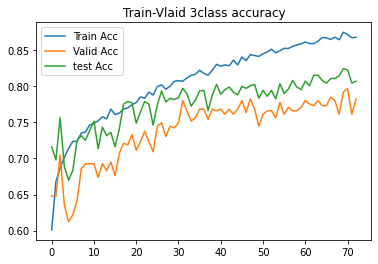

epoch 73 loss: 0.2844: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.36it/s]


train 2class accuracy = 0.87281
[[5816  737]
 [ 930 5623]]


epoch 73 loss: 0.7522: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.36it/s]


validation 2class accuracy = 0.78487
[[ 46  43]
 [ 48 286]]


epoch 73 loss: 0.6096: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.97it/s]


test 2class accuracy = 0.80619
[[105  94]
 [119 781]]


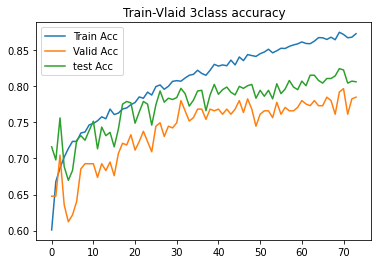

epoch 74 loss: 0.2838: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.33it/s]


train 2class accuracy = 0.87067
[[5784  769]
 [ 926 5627]]


epoch 74 loss: 0.7382: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.16it/s]


validation 2class accuracy = 0.78487
[[ 45  44]
 [ 47 287]]


epoch 74 loss: 0.5855: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.81it/s]


test 2class accuracy = 0.81620
[[103  96]
 [106 794]]


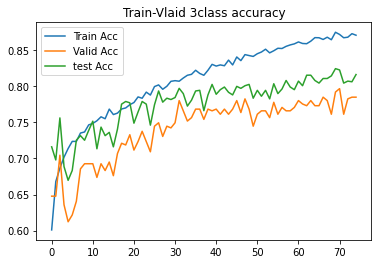

epoch 75 loss: 0.2990: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.34it/s]


train 2class accuracy = 0.87548
[[5827  726]
 [ 906 5647]]


epoch 75 loss: 0.7504: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.56it/s]


validation 2class accuracy = 0.78014
[[ 42  47]
 [ 46 288]]


epoch 75 loss: 0.5728: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.26it/s]


test 2class accuracy = 0.82166
[[102  97]
 [ 99 801]]


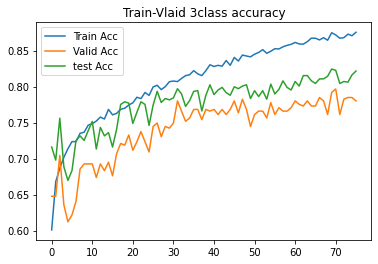

epoch 76 loss: 0.2841: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.37it/s]


train 2class accuracy = 0.87655
[[5826  727]
 [ 891 5662]]


epoch 76 loss: 0.7345: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.30it/s]


validation 2class accuracy = 0.78014
[[ 42  47]
 [ 46 288]]


epoch 76 loss: 0.5745: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.08it/s]


test 2class accuracy = 0.82348
[[102  97]
 [ 97 803]]


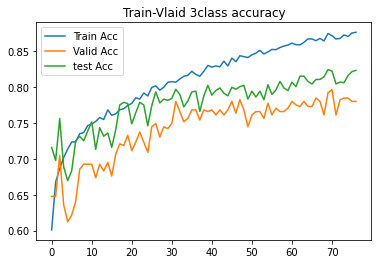

epoch 77 loss: 0.2755: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.35it/s]


train 2class accuracy = 0.87761
[[5842  711]
 [ 893 5660]]


epoch 77 loss: 0.7468: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.67it/s]


validation 2class accuracy = 0.76832
[[ 43  46]
 [ 52 282]]


epoch 77 loss: 0.6176: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.40it/s]


test 2class accuracy = 0.80346
[[105  94]
 [122 778]]


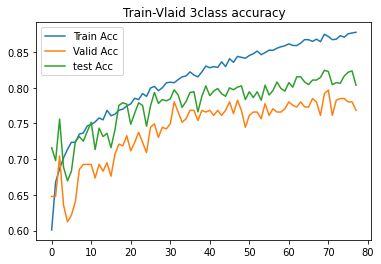

epoch 78 loss: 0.2772: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.34it/s]


train 2class accuracy = 0.87975
[[5878  675]
 [ 901 5652]]


epoch 78 loss: 0.8223: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.39it/s]


validation 2class accuracy = 0.79433
[[ 41  48]
 [ 39 295]]


epoch 78 loss: 0.6138: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.08it/s]


test 2class accuracy = 0.82348
[[ 96 103]
 [ 91 809]]


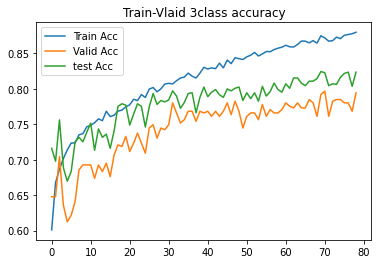

epoch 79 loss: 0.2802: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.37it/s]


train 2class accuracy = 0.87700
[[5828  725]
 [ 887 5666]]


epoch 79 loss: 0.7623: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.43it/s]


validation 2class accuracy = 0.78960
[[ 39  50]
 [ 39 295]]


epoch 79 loss: 0.6061: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.27it/s]


test 2class accuracy = 0.82621
[[ 92 107]
 [ 84 816]]


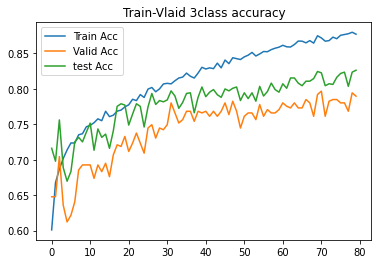

epoch 80 loss: 0.2762: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:38<00:00,  8.28it/s]


train 2class accuracy = 0.87532
[[5816  737]
 [ 897 5656]]


epoch 80 loss: 0.8314: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.06it/s]


validation 2class accuracy = 0.78251
[[ 39  50]
 [ 42 292]]


epoch 80 loss: 0.6420: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.52it/s]


test 2class accuracy = 0.81620
[[ 96 103]
 [ 99 801]]


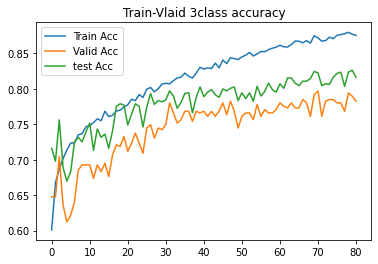

epoch 81 loss: 0.2596: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.32it/s]


train 2class accuracy = 0.88242
[[5867  686]
 [ 855 5698]]


epoch 81 loss: 0.8043: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.34it/s]


validation 2class accuracy = 0.77541
[[ 43  46]
 [ 49 285]]


epoch 81 loss: 0.6388: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.92it/s]


test 2class accuracy = 0.81984
[[ 99 100]
 [ 98 802]]


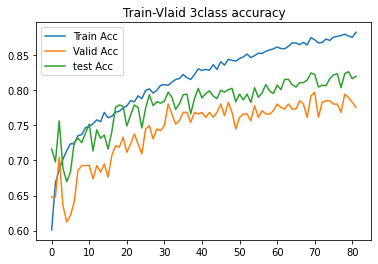

epoch 82 loss: 0.2559: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.33it/s]


train 2class accuracy = 0.88273
[[5865  688]
 [ 849 5704]]


epoch 82 loss: 0.7751: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.32it/s]


validation 2class accuracy = 0.76832
[[ 41  48]
 [ 50 284]]


epoch 82 loss: 0.6292: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.87it/s]


test 2class accuracy = 0.81529
[[107  92]
 [111 789]]


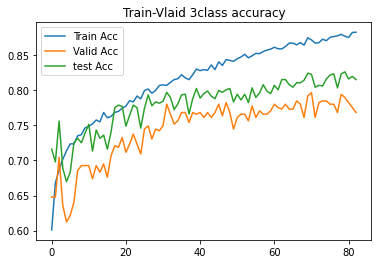

epoch 83 loss: 0.2510: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:36<00:00,  8.37it/s]


train 2class accuracy = 0.88120
[[5872  681]
 [ 876 5677]]


epoch 83 loss: 0.7791: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.34it/s]


validation 2class accuracy = 0.79905
[[ 40  49]
 [ 36 298]]


epoch 83 loss: 0.5794: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.05it/s]


test 2class accuracy = 0.82348
[[ 87 112]
 [ 82 818]]


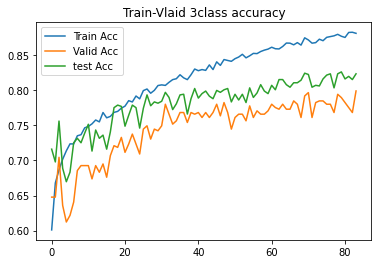

epoch 84 loss: 0.2743: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:35<00:00,  8.41it/s]


train 2class accuracy = 0.88532
[[5895  658]
 [ 845 5708]]


epoch 84 loss: 0.8171: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.15it/s]


validation 2class accuracy = 0.78014
[[ 43  46]
 [ 47 287]]


epoch 84 loss: 0.6160: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.70it/s]


test 2class accuracy = 0.81165
[[106  93]
 [114 786]]


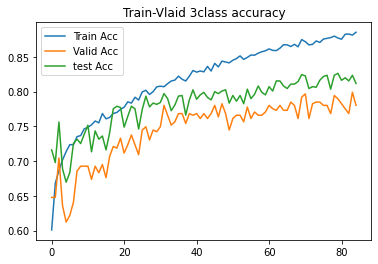

epoch 85 loss: 0.2826: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.48it/s]


train 2class accuracy = 0.88105
[[5883  670]
 [ 889 5664]]


epoch 85 loss: 0.8000: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.33it/s]


validation 2class accuracy = 0.79905
[[ 37  52]
 [ 33 301]]


epoch 85 loss: 0.6523: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.18it/s]


test 2class accuracy = 0.81802
[[ 82 117]
 [ 83 817]]


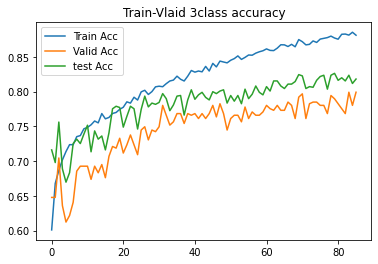

epoch 86 loss: 0.2552: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.55it/s]


train 2class accuracy = 0.88349
[[5851  702]
 [ 825 5728]]


epoch 86 loss: 0.7996: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.09it/s]


validation 2class accuracy = 0.76832
[[ 44  45]
 [ 53 281]]


epoch 86 loss: 0.6318: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.86it/s]


test 2class accuracy = 0.80619
[[117  82]
 [131 769]]


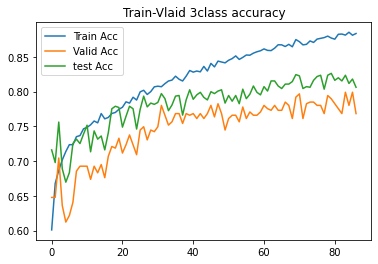

epoch 87 loss: 0.2668: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.53it/s]


train 2class accuracy = 0.88410
[[5884  669]
 [ 850 5703]]


epoch 87 loss: 0.7303: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.12it/s]


validation 2class accuracy = 0.78251
[[ 41  48]
 [ 44 290]]


epoch 87 loss: 0.6258: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 19.01it/s]


test 2class accuracy = 0.80983
[[ 97 102]
 [107 793]]


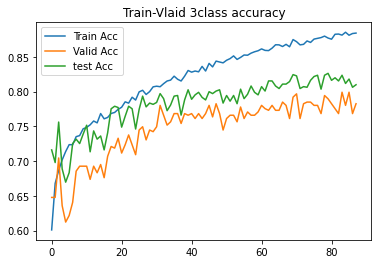

epoch 88 loss: 0.2500: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.51it/s]


train 2class accuracy = 0.88990
[[5905  648]
 [ 795 5758]]


epoch 88 loss: 0.7755: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.97it/s]


validation 2class accuracy = 0.78487
[[ 43  46]
 [ 45 289]]


epoch 88 loss: 0.6237: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.83it/s]


test 2class accuracy = 0.81802
[[ 97 102]
 [ 98 802]]


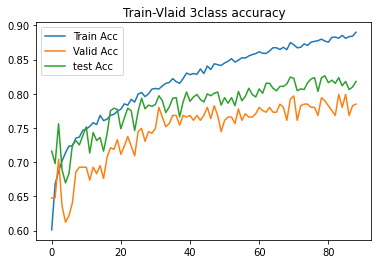

epoch 89 loss: 0.2446: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.55it/s]


train 2class accuracy = 0.88601
[[5890  663]
 [ 831 5722]]


epoch 89 loss: 0.8394: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.09it/s]


validation 2class accuracy = 0.78723
[[ 42  47]
 [ 43 291]]


epoch 89 loss: 0.6890: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.72it/s]


test 2class accuracy = 0.81165
[[ 96 103]
 [104 796]]


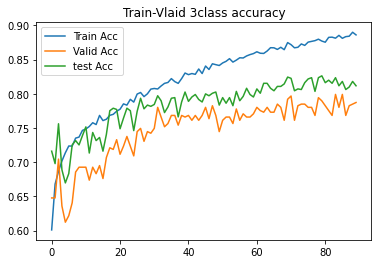

epoch 90 loss: 0.2342: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.56it/s]


train 2class accuracy = 0.89074
[[5907  646]
 [ 786 5767]]


epoch 90 loss: 0.7900: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.13it/s]


validation 2class accuracy = 0.77541
[[ 40  49]
 [ 46 288]]


epoch 90 loss: 0.6527: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.84it/s]


test 2class accuracy = 0.80710
[[ 93 106]
 [106 794]]


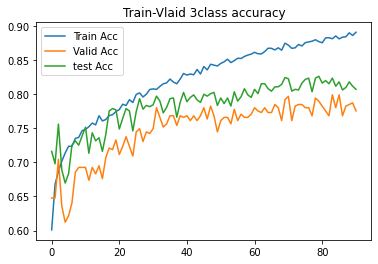

epoch 91 loss: 0.2451: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.52it/s]


train 2class accuracy = 0.89463
[[5945  608]
 [ 773 5780]]


epoch 91 loss: 0.8518: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.26it/s]


validation 2class accuracy = 0.79196
[[ 42  47]
 [ 41 293]]


epoch 91 loss: 0.6774: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.98it/s]


test 2class accuracy = 0.81529
[[ 93 106]
 [ 97 803]]


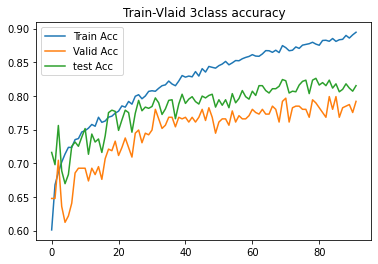

epoch 92 loss: 0.2506: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.50it/s]


train 2class accuracy = 0.89119
[[5926  627]
 [ 799 5754]]


epoch 92 loss: 0.8310: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.27it/s]


validation 2class accuracy = 0.79433
[[ 41  48]
 [ 39 295]]


epoch 92 loss: 0.6750: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.80it/s]


test 2class accuracy = 0.81256
[[ 89 110]
 [ 96 804]]


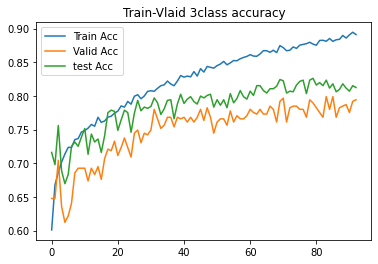

epoch 93 loss: 0.2394: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:33<00:00,  8.54it/s]


train 2class accuracy = 0.89104
[[5922  631]
 [ 797 5756]]


epoch 93 loss: 0.8166: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 20.18it/s]


validation 2class accuracy = 0.77541
[[ 42  47]
 [ 48 286]]


epoch 93 loss: 0.6842: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.72it/s]


test 2class accuracy = 0.80346
[[ 93 106]
 [110 790]]


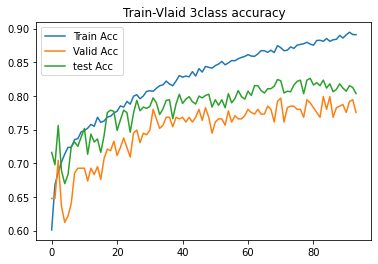

epoch 94 loss: 0.2514: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:34<00:00,  8.51it/s]


train 2class accuracy = 0.89036
[[5914  639]
 [ 798 5755]]


epoch 94 loss: 0.8011: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.96it/s]


validation 2class accuracy = 0.78723
[[ 38  51]
 [ 39 295]]


epoch 94 loss: 0.6102: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.81it/s]


test 2class accuracy = 0.80892
[[ 88 111]
 [ 99 801]]


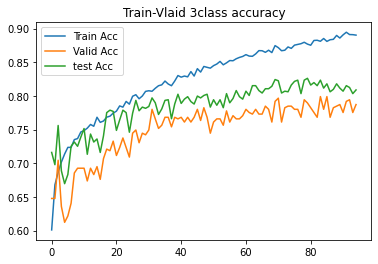

epoch 95 loss: 0.2596: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.33it/s]


train 2class accuracy = 0.88776
[[5904  649]
 [ 822 5731]]


epoch 95 loss: 0.8192: 100%|███████████████████████████████████████████████████████████| 43/43 [00:03<00:00, 13.69it/s]


validation 2class accuracy = 0.79196
[[ 36  53]
 [ 35 299]]


epoch 95 loss: 0.6751: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 16.12it/s]


test 2class accuracy = 0.81256
[[ 74 125]
 [ 81 819]]


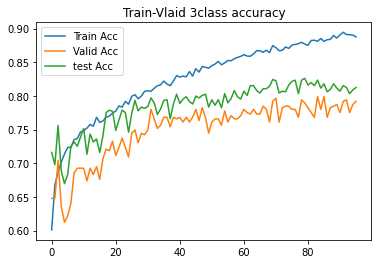

epoch 96 loss: 0.2502: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:37<00:00,  8.33it/s]


train 2class accuracy = 0.89264
[[5924  629]
 [ 778 5775]]


epoch 96 loss: 0.8557: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.80it/s]


validation 2class accuracy = 0.79196
[[ 43  46]
 [ 42 292]]


epoch 96 loss: 0.7017: 100%|█████████████████████████████████████████████████████████| 110/110 [00:05<00:00, 18.68it/s]


test 2class accuracy = 0.80892
[[ 86 113]
 [ 97 803]]


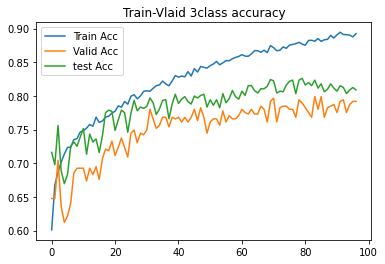

epoch 97 loss: 0.2472: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:40<00:00,  8.15it/s]


train 2class accuracy = 0.89089
[[5918  635]
 [ 795 5758]]


epoch 97 loss: 0.8803: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 18.24it/s]


validation 2class accuracy = 0.80142
[[ 37  52]
 [ 32 302]]


epoch 97 loss: 0.6721: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 17.67it/s]


test 2class accuracy = 0.81802
[[ 77 122]
 [ 78 822]]


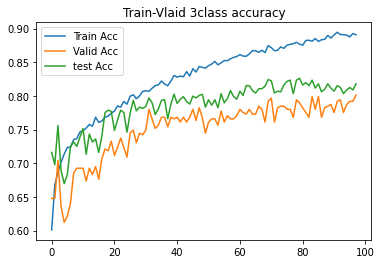

epoch 98 loss: 0.2223: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:44<00:00,  7.99it/s]


train 2class accuracy = 0.89486
[[5939  614]
 [ 764 5789]]


epoch 98 loss: 0.9224: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.11it/s]


validation 2class accuracy = 0.80378
[[ 39  50]
 [ 33 301]]


epoch 98 loss: 0.6907: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.26it/s]


test 2class accuracy = 0.81529
[[ 78 121]
 [ 82 818]]


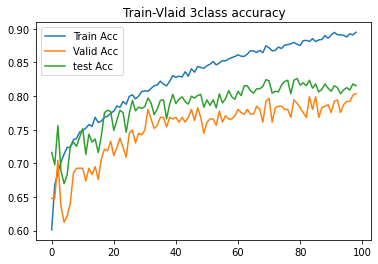

epoch 99 loss: 0.2485: 100%|███████████████████████████████████████████████████████| 1311/1311 [02:39<00:00,  8.21it/s]


train 2class accuracy = 0.89608
[[5949  604]
 [ 758 5795]]


epoch 99 loss: 0.8345: 100%|███████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.11it/s]


validation 2class accuracy = 0.79905
[[ 38  51]
 [ 34 300]]


epoch 99 loss: 0.6512: 100%|█████████████████████████████████████████████████████████| 110/110 [00:06<00:00, 18.06it/s]


test 2class accuracy = 0.82621
[[ 76 123]
 [ 68 832]]


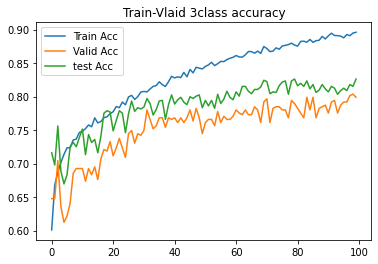

time : 4:32:23
Best Epoch : 98
Best Train Accuracy : 0.89486
[[5939  614]
 [ 764 5789]]
Best Valid Accuracy : 0.80378
[[ 39  50]
 [ 33 301]]


In [31]:
model_dir = '../models/230105/{}'.format(CFG['model_arch'])
trn_root='D:/project/wl_3class/train'
val_root='D:/project/wl_3class/valid'
tst_root='D:/project/wl_3class/test'


wandb.init(project="wl_2class", entity="kyungbin")
wandb.run.name = '2class_v1_renewal'

# Optional"
wandb.watch(model)


if __name__ == '__main__':
     # for training only, need nightly build pytorch
    
    seed_everything(CFG['seed'])
    
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
    
        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader, tst_loader = prepare_dataloader(train,valid,test ,trn_idx, val_idx, trn_root,val_root,tst_root)

        device = torch.device(CFG['device'])
        
        model = ColonImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)

        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], 
                                     #weight_decay=CFG['weight_decay']
                                    )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=25)
#         scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        #scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps=5, base_lr=0.3, final_lr=0.01)
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        loss_fn1 = nn.CrossEntropyLoss().to(device)
        
        train_acc_list = []
        train_matrix_list = []
        valid_acc_list = []
        valid_matrix_list = []
        test_acc_list = []
        test_matrix_list = []
        
        
        
        start = time.time()
        for epoch in range(CFG['epochs']):
            
            train_preds_all, train_acc, train_matrix,train_loss = train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, 
                                                                       scheduler=None, schd_batch_update=False)
            
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_matrix,valid_loss= valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)
                test_preds_all, test_acc, test_matrix,test_loss= test_one_epoch(epoch, model, loss_fn1, tst_loader, device, scheduler=None, schd_loss_update=False)

                
            torch.save(model.state_dict(), (model_dir+'/2class_v1_renewal_{}_fold_{}_{}').format(CFG['model_arch'], fold, epoch))
            
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            test_acc_list.append(test_acc)
            test_matrix_list.append(test_matrix)
        
            plt.plot(train_acc_list, label='Train Acc')
            plt.plot(valid_acc_list, label='Valid Acc')
            plt.plot(test_acc_list, label='test Acc')
            plt.title('Train-Vlaid 3class accuracy')
            plt.legend()
            plt.show()
            
            
            wandb.log({"valid_loss": valid_loss,
                       "valid_accuracy":valid_acc,
                       "test_loss": test_loss,
                       #"valid_recall": valid_recall,
          "train_loss": train_loss,
          "train Acc": train_acc,
          "test acc ": test_acc
          })
            
            
            
            
        
        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)
            
        best_index = valid_acc_list.index(max(valid_acc_list))
        print(f'Best Epoch : {best_index}')
        print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        
        del model, optimizer, train_loader, val_loader,tst_loader, scaler
        torch.cuda.empty_cache()
        
        # we'll train fold 0 first
        if fold == 0:
            break 

    train_preds_all = train_preds_all
    valid_preds_all = valid_preds_all
    test_preds_all = test_preds_all